In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.linalg import eigh
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
import warnings
warnings.filterwarnings("ignore")
import random

In [2]:
# Create a stochastic block model graph with three communities
# sizes = [15, 15, 15] # Sizes of the communities
# probs = [[0.7, 0.05, 0.02], # Probabilities of edges within and between communities
#          [0.05, 0.7, 0.07], 
#          [0.02, 0.07, 0.7]]
# G = nx.stochastic_block_model(sizes, probs)
# Add weights to the edges

# for u, v, d in G.edges(data=True):
#     d['weight'] = random.randint(1, 50)
    
G = nx.karate_club_graph()

In [3]:
# # Create an empty graph
# G = nx.Graph()

# # Add some nodes
# for i in range(100):
#     G.add_node(i)

# # Randomly add some edges with random weights
# for i in range(100):
#     for j in range(i+1, 100):
#         if i != j:
#             if random.random() < 0.4:  # 40% chance of adding an edge
#                 weight = random.randint(1, 100)  # Weight between 1 and 10
#                 G.add_edge(i, j, weight=weight)

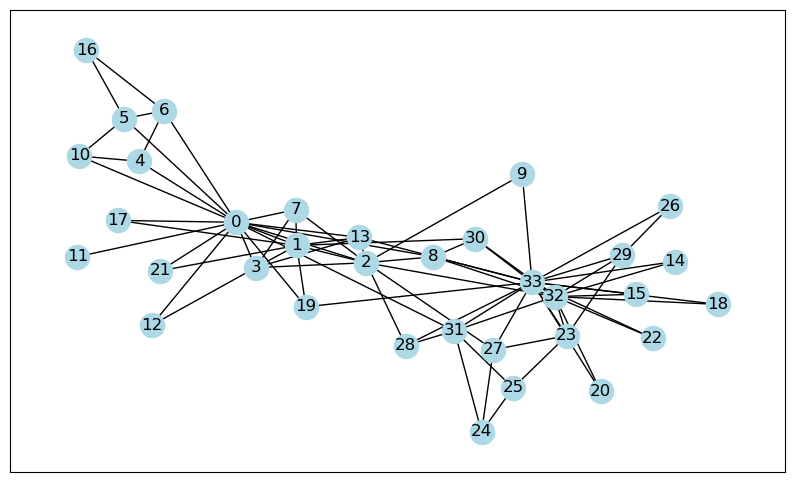

In [4]:
fig = plt.figure(figsize=(10, 6))  # Adjust size as needed

pos = nx.spring_layout(G)
# nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue')

# edges
nx.draw_networkx_edges(G, pos)

# labels
nx.draw_networkx_labels(G, pos)

edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [5]:
print(nx.diameter(G))
print(nx.average_shortest_path_length(G))
degrees = [G.degree(n) for n in G.nodes()]
print("Average degree:", sum(degrees) / len(degrees))

5
2.408199643493761
Average degree: 4.588235294117647


In [6]:
nx.to_numpy_array(G)

array([[0., 4., 5., ..., 2., 0., 0.],
       [4., 0., 6., ..., 0., 0., 0.],
       [5., 6., 0., ..., 0., 2., 0.],
       ...,
       [2., 0., 0., ..., 0., 4., 4.],
       [0., 0., 2., ..., 4., 0., 5.],
       [0., 0., 0., ..., 4., 5., 0.]])

In [7]:
# Get the Laplacian matrix of the graph
L = nx.normalized_laplacian_matrix(G).todense()

# Compute the eigenvalues and eigenvectors
eigvals, eigvecs = eigh(L)

In [8]:
# Sort the eigenvalues
eigvals = np.sort(eigvals)

# Compute the differences between consecutive eigenvalues
gaps = np.diff(eigvals)

# The number of clusters is the position of the maximum gap, plus one
k = dims = np.argmax(gaps) + 1

dims

3

In [9]:
# Use the eigenvectors corresponding to the two smallest non-zero eigenvalues to create 2D embeddings
embeddings = np.array(eigvecs[:, 1:4])

In [10]:
embeddings.shape

(34, 3)

In [11]:
# Use k-means to cluster the nodes based on their embeddings
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(embeddings)

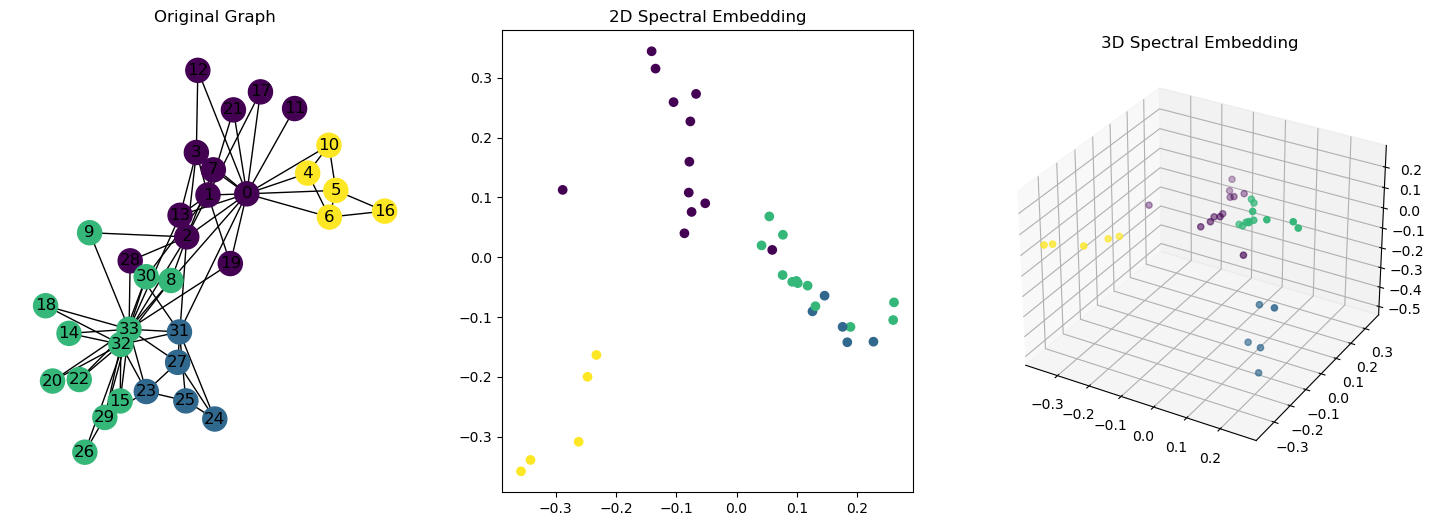

In [29]:
# Create subplots
fig = plt.figure(figsize=(18, 6))  # Adjust size as needed

# Draw the original graph
ax1 = fig.add_subplot(131)
nx.draw(G, node_color=labels, with_labels=True, ax=ax1)
ax1.title.set_text('Original Graph')

# Draw the 2D embeddings
ax2 = fig.add_subplot(132)
ax2.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
ax2.title.set_text('2D Spectral Embedding')

# Draw the 3D embeddings
ax3 = fig.add_subplot(133, projection='3d')
scatter = ax3.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels)
ax3.title.set_text('3D Spectral Embedding')

plt.show()

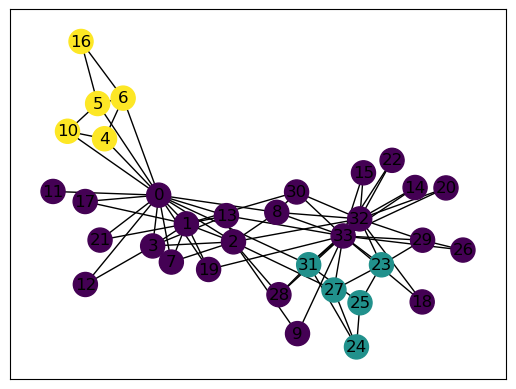

In [13]:
# Draw the original graph
nx.draw_networkx(G, node_color=labels, with_labels=True)

plt.show()

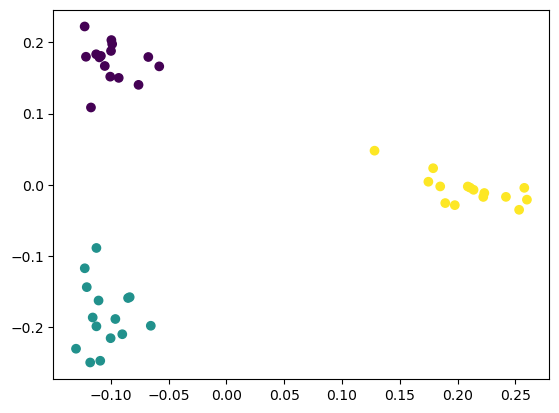

In [13]:
# Draw the 2D embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
plt.show()

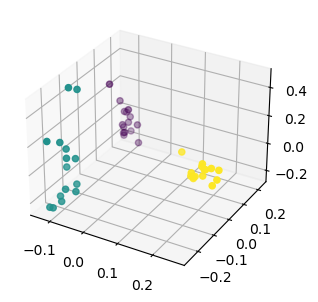

In [14]:
# Create subplots
fig = plt.figure(figsize=(12, 7))  # Adjust size as needed

ax3 = fig.add_subplot(131, projection='3d')
scatter = ax3.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels)

plt.show()

In [15]:
embeddings.shape

(45, 3)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Flatten the matrix into a 1D array
similarity_values = similarity_matrix.flatten()

In [14]:
n_bins = int(np.sqrt(len(similarity_values)))
n_bins

90

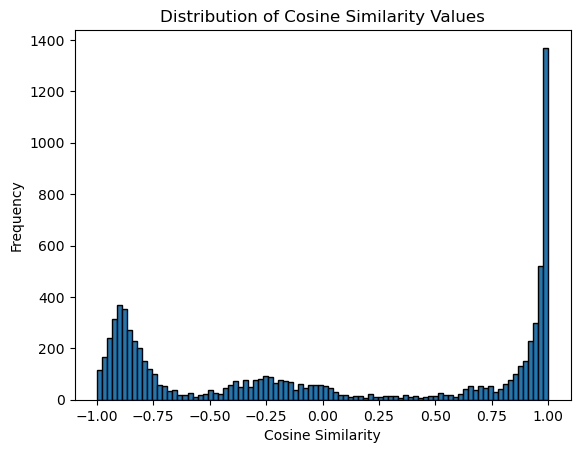

In [15]:
plt.hist(similarity_values, bins=n_bins, edgecolor='black')
plt.title('Distribution of Cosine Similarity Values')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Get the histogram bins and frequencies
freq, bins = np.histogram(similarity_values, bins=n_bins)

# Find the index of the bin with the lowest frequency
min_freq_idx = np.argmin(freq)

# The bin with the lowest frequency is then (bins[min_freq_idx], bins[min_freq_idx + 1])
print(f"The bin with the lowest frequency is ({bins[min_freq_idx]}, {bins[min_freq_idx + 1]})")
threshold = np.mean([bins[min_freq_idx], bins[min_freq_idx + 1]])
threshold

The bin with the lowest frequency is (0.17859872763432416, 0.2007987620225855)


0.18969874482845483

In [21]:
def prune_graph(graph):

    # import needed functions
    from networkx import to_numpy_array, is_connected, connected_components

    # convert graph to adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)


    # edges before pruning
    init_edges = graph.number_of_edges()
    # keep trach of deleted edges
    cut_edges = 0

    # Remove edges between nodes in different clusters
    for u, v in graph.edges():
        
        sim = cosine_similarity([embeddings[u, :],  embeddings[v, :]])[0][1] 

        if labels[u] != labels[v]:
            if sim <= threshold:
                graph.remove_edge(u, v)
                cut_edges += 1
        else:
            if sim <= 2 * np.abs(threshold):
                graph.remove_edge(u, v)
                cut_edges += 1

    prune_percentage = cut_edges/init_edges*100
    print(f"{prune_percentage} % pruning. {cut_edges} edges were pruned out of {init_edges}.")

    return graph

In [22]:
Gprime = prune_graph(G)

9.606656580937972 % pruning. 127 edges were pruned out of 1322.


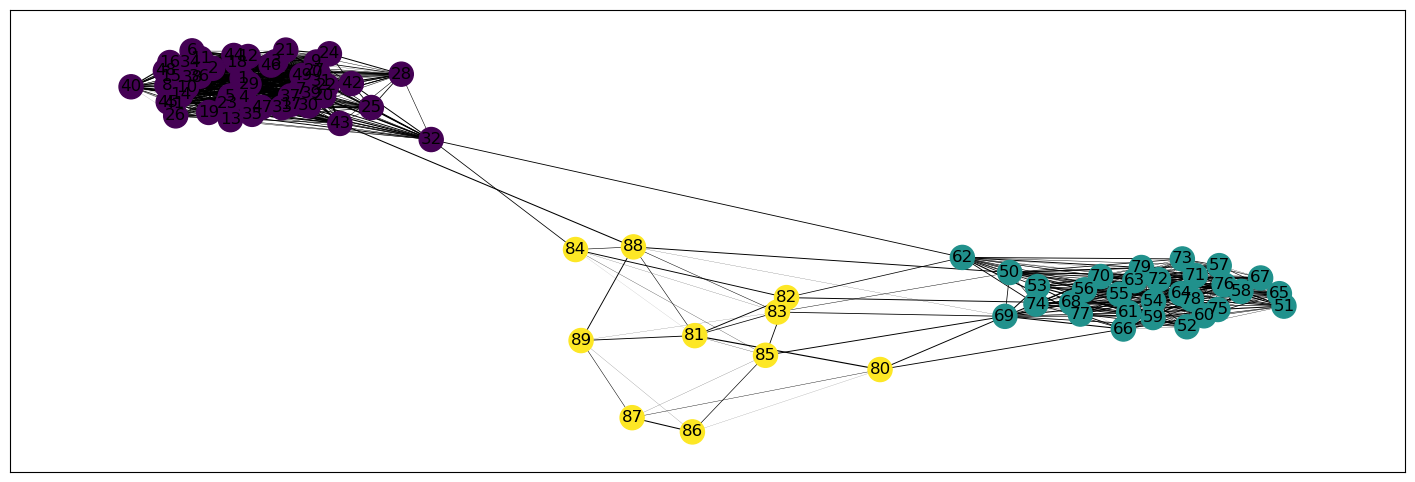

In [23]:
# Create subplots
fig = plt.figure(figsize=(18, 6))  # Adjust size as needed

pos = nx.spring_layout(Gprime)
# nodes
nx.draw_networkx_nodes(Gprime, pos, node_color=labels)

# edges
nx.draw_networkx_edges(Gprime, pos, width=[d['weight']/60 for (u, v, d) in Gprime.edges(data=True)])

# labels
nx.draw_networkx_labels(Gprime, pos)

edge_labels = nx.get_edge_attributes(Gprime, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [24]:
print(nx.diameter(G))
print(nx.average_shortest_path_length(G))
degrees = [G.degree(n) for n in G.nodes()]
print("Average degree:", sum(degrees) / len(degrees))

5
2.5325842696629213
Average degree: 26.555555555555557


In [25]:
adj_matrix = nx.to_numpy_array(Gprime)

In [26]:
labels = SpectralClustering(n_clusters=3, n_components=dims, affinity='precomputed').fit_predict(adj_matrix)

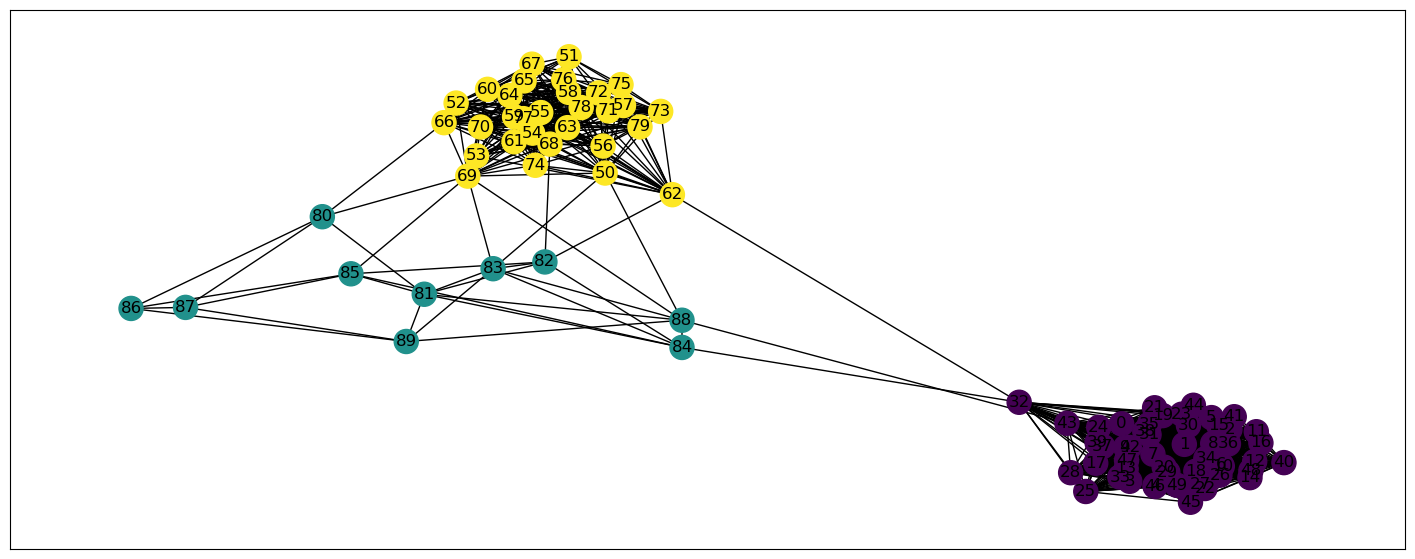

In [27]:
# Figure size
plt.figure(figsize=(18, 7))  # Increase DPI
# Draw the graph, colored by the cluster labels
nx.draw_networkx(G, node_color=labels, with_labels=True)
plt.show()